In [2]:
import zipfile
import os

# Unzip stock.zip into nifty_data directory
with zipfile.ZipFile('stock.zip', 'r') as zip_ref:
    zip_ref.extractall('nifty_data')

# Verify the contents of the directory
os.listdir('nifty_data')

['AXISBANK.csv',
 'MARUTI.csv',
 'TATASTEEL.csv',
 'ZEEL.csv',
 'BRITANNIA.csv',
 'UPL.csv',
 'stock_metadata.csv',
 'BHARTIARTL.csv',
 'LT.csv',
 'CIPLA.csv',
 'TITAN.csv',
 'ADANIPORTS.csv',
 'INFRATEL.csv',
 'SHREECEM.csv',
 'INDUSINDBK.csv',
 'ASIANPAINT.csv',
 'SBIN.csv',
 'SUNPHARMA.csv',
 'EICHERMOT.csv',
 'NESTLEIND.csv',
 'NTPC.csv',
 'GAIL.csv',
 'ULTRACEMCO.csv',
 'ONGC.csv',
 'JSWSTEEL.csv',
 'HDFCBANK.csv',
 'IOC.csv',
 'DRREDDY.csv',
 'HEROMOTOCO.csv',
 'ITC.csv',
 'TCS.csv',
 'GRASIM.csv',
 'TATAMOTORS.csv',
 'VEDL.csv',
 'BAJAJFINSV.csv',
 'HINDUNILVR.csv',
 'HINDALCO.csv',
 'MM.csv',
 'HCLTECH.csv',
 'BAJFINANCE.csv',
 'POWERGRID.csv',
 'NIFTY50_all.csv',
 'HDFC.csv',
 'BAJAJ-AUTO.csv',
 'KOTAKBANK.csv',
 'INFY.csv',
 'WIPRO.csv',
 'BPCL.csv',
 'ICICIBANK.csv',
 'RELIANCE.csv',
 'COALINDIA.csv',
 'TECHM.csv']

In [3]:
!pip install yfinance plotly pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Load Nifty 50 data from uploaded stock.zip file
nifty_data = yf.download('^NSEI', start='2003-01-01', end='2023-01-01')
nifty_data.reset_index(inplace=True)

# Check the first few rows
nifty_data.head()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


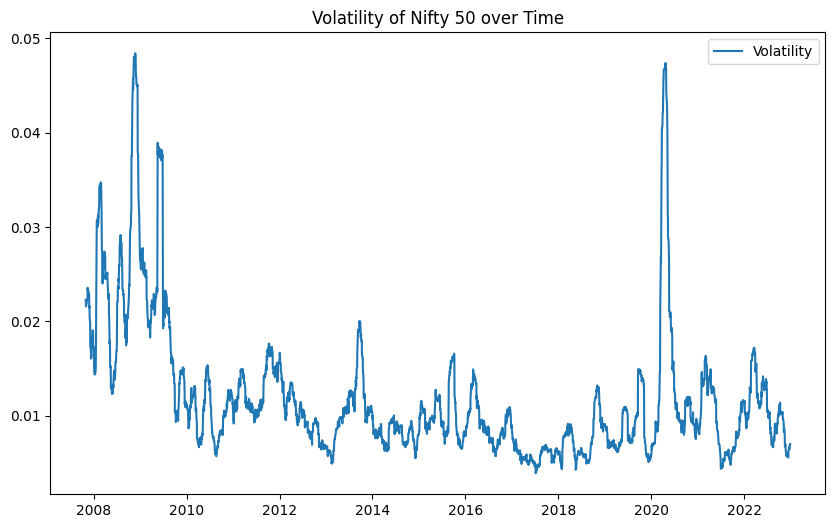

In [5]:
# Calculating Daily Returns
nifty_data['Daily Return'] = nifty_data['Adj Close'].pct_change()

# 30-day Moving Average
nifty_data['MA30'] = nifty_data['Adj Close'].rolling(window=30).mean()

# Volatility Indicator - Rolling Standard Deviation
nifty_data['Volatility'] = nifty_data['Daily Return'].rolling(window=30).std()

# Bollinger Bands
nifty_data['Upper Band'] = nifty_data['MA30'] + (nifty_data['Volatility'] * 2)
nifty_data['Lower Band'] = nifty_data['MA30'] - (nifty_data['Volatility'] * 2)

# Plotting Daily Return and Volatility
plt.figure(figsize=(10,6))
plt.plot(nifty_data['Date'], nifty_data['Volatility'], label='Volatility')
plt.title('Volatility of Nifty 50 over Time')
plt.legend()
plt.show()


[*********************100%***********************]  3 of 3 completed


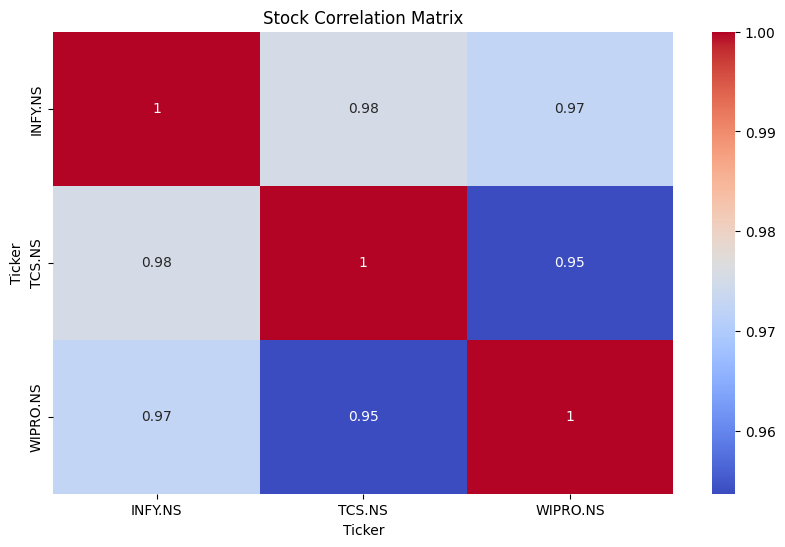

In [8]:
# Loading individual stock data for a portfolio
stocks = ['TCS.NS', 'WIPRO.NS', 'INFY.NS']
stock_data = yf.download(stocks, start='2003-01-01', end='2023-01-01')['Adj Close']

# Correlation Heatmap for stock selection
plt.figure(figsize=(10,6))
sns.heatmap(stock_data.corr(), annot=True, cmap='coolwarm')
plt.title('Stock Correlation Matrix')
plt.show()



In [9]:
import plotly.graph_objs as go

# Create traces for stock price movement
trace1 = go.Scatter(x=nifty_data['Date'], y=nifty_data['Adj Close'], mode='lines', name='Nifty 50')

layout = go.Layout(title='Nifty 50 Price Movement',
                   xaxis_title='Date',
                   yaxis_title='Price')
fig = go.Figure(data=[trace1], layout=layout)

fig.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


R2 Score: 0.9992185145064363
Mean Squared Error: 11944.273455941746


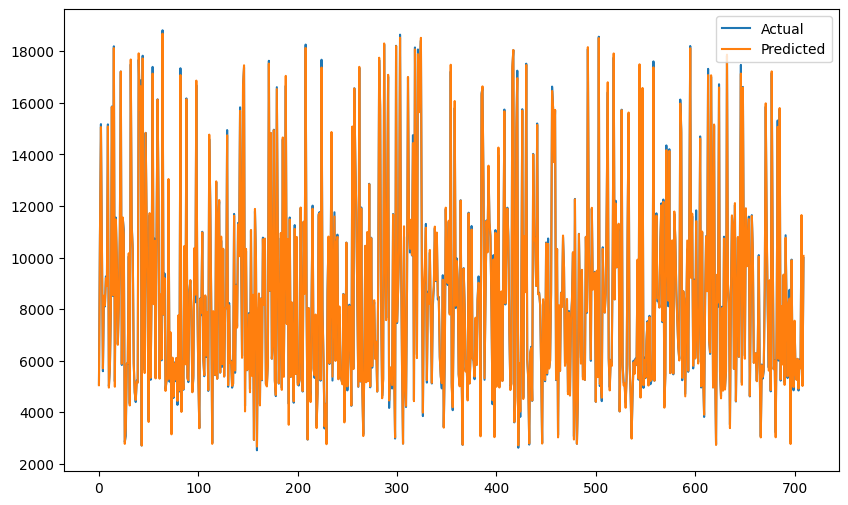

In [10]:
# Feature Engineering: Adding Moving Averages and Lag Features
nifty_data['MA50'] = nifty_data['Adj Close'].rolling(window=50).mean()
nifty_data['MA200'] = nifty_data['Adj Close'].rolling(window=200).mean()

# Lag features
nifty_data['Lag1'] = nifty_data['Adj Close'].shift(1)
nifty_data['Lag2'] = nifty_data['Adj Close'].shift(2)

# Dropping NaN values
nifty_data = nifty_data.dropna()

# Splitting the dataset into train and test
X = nifty_data[['MA30', 'Volatility', 'Lag1', 'Lag2']]
y = nifty_data['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

# Plotting actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [52]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Step 1: Load stock data for portfolio analysis

stocks = ['HDFCBANK.NS', 'TATAMOTORS.NS', 'INFY.NS', 'RELIANCE.NS', 'SUNPHARMA.NS']
stock_data = yf.download(stocks, start='2003-01-01', end='2023-01-01')['Adj Close']


[*********************100%***********************]  5 of 5 completed


In [53]:
# Step 2: Calculate Daily Returns
daily_returns = stock_data.pct_change().dropna()

<ipython-input-53-42a61a4a6b0d>:2: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [55]:
# Step 3: Calculate Annualized Mean Return and Covariance Matrix
annual_returns = daily_returns.mean() * 252  # Assuming 252 trading days per year
cov_matrix = daily_returns.cov() * 252

In [56]:
# Step 4: Portfolio Optimization (Max Sharpe Ratio)
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.sum(returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe_ratio(weights, returns, cov_matrix):
    return -portfolio_performance(weights, returns, cov_matrix)[2]

# Constraints: Weights must sum to 1, and all weights must be between 0 and 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(stocks)))

# Initial guess (equal weights)
initial_weights = [1 / len(stocks)] * len(stocks)

# Optimize portfolio
opt_result = minimize(negative_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x
portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_performance(optimal_weights, annual_returns, cov_matrix)

In [57]:
# Step 5: Display Results
print("Optimal Portfolio Weights:")
for i, stock in enumerate(stocks):
    print(f"{stock}: {optimal_weights[i]:.4f}")

print(f"\nExpected Annual Return: {portfolio_return:.2f}")
print(f"Annual Volatility (Risk): {portfolio_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Optimal Portfolio Weights:
HDFCBANK.NS: 0.3338
TATAMOTORS.NS: 0.1948
INFY.NS: 0.1245
RELIANCE.NS: 0.3469
SUNPHARMA.NS: 0.0000

Expected Annual Return: 0.27
Annual Volatility (Risk): 0.22
Sharpe Ratio: 1.20


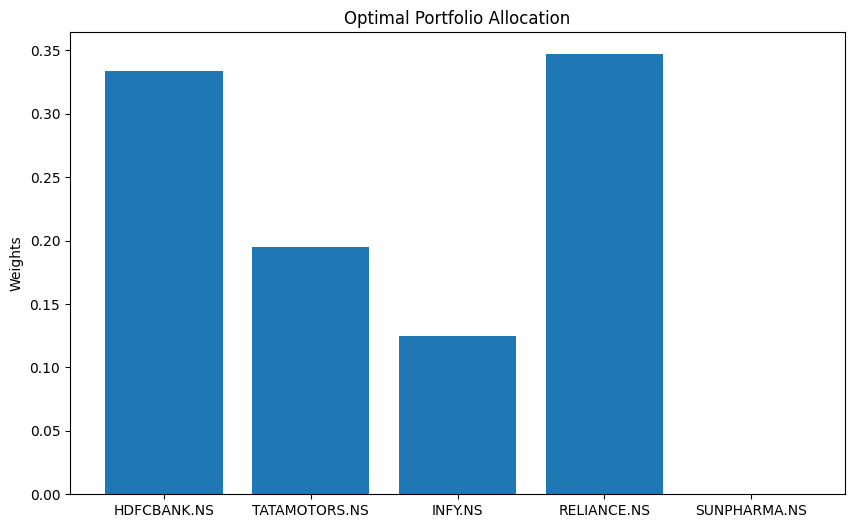

In [58]:
# Step 6: Plotting the Portfolio Weights
plt.figure(figsize=(10,6))
plt.bar(stocks, optimal_weights)
plt.title('Optimal Portfolio Allocation')
plt.ylabel('Weights')
plt.show()